In [1]:
%matplotlib inline

import fs
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
from datetime import datetime, timedelta

DATA_DIR = '../data/wiki_crop'
WIKI_META_FILE = 'wiki.mat'

In [96]:
lmap = lambda f, l: list(map(f, l))
lfilter = lambda f, l: list(filter(f, l))

python_datetime = lambda x: datetime.fromordinal(int(x)) + timedelta(days=int(x)%1) - timedelta(days = 366)
python_datetime_vec = np.vectorize(python_datetime)

get_year_vec = np.vectorize(lambda x: x.year)
to_string_vec = np.vectorize(lambda x: str(x)[2:-2])

def get_meta_data(filename):
    # Read input file
    meta = scipy.io.loadmat(fs.join(DATA_DIR, filename))
    
    dob_timestamp = np.asarray(meta['wiki'][0][0][0])
    photo_taken_year = np.asarray(meta['wiki'][0][0][1])
    full_path = np.asarray(meta['wiki'][0][0][2])
    gender = np.asarray(meta['wiki'][0][0][3])
    name = np.asarray(meta['wiki'][0][0][4])
    face_location = np.asarray(meta['wiki'][0][0][5])
    face_score = np.asarray(meta['wiki'][0][0][6])
    face_score_2 = np.asarray(meta['wiki'][0][0][7])
    
    # Parse Matlab date
    dob_timestamp = python_datetime_vec(dob_timestamp[0,:])
    age = photo_taken_year[0,:] - get_year_vec(dob_timestamp)
    
    return {
        'path':   to_string_vec(full_path[0,:]),
        'name':   to_string_vec(name[0,:]),
        'age':    age,
        'gender': gender[0,:].astype(int)
    }

def to_bins(data, bins):
    bin_labels = lmap(lambda b: '%s-%s' % b, bins)
    
    bins.append((-1, -1))
    bin_labels.append('other')
    
    binarize = lambda x: bins.index(next(filter(lambda e: x >= e[0] and x <= e[1], bins), bins[-1]))
    binarize_vec = np.vectorize(binarize)
    return binarize_vec(data), bin_labels
    
def plot_histo(data, bins=30, range=(0,100), figsize=(20,10), xticks=None):
    hist, bin_edges = np.histogram(data, bins=bins, range=range)

    plt.figure(figsize=figsize)
    plt.bar(bin_edges[:-1], hist, width=1)
    plt.xlim(min(bin_edges), max(bin_edges))
    if xticks is not None:
        plt.xticks(np.arange(len(xticks)) + 0.5, xticks)
    plt.show()

In [24]:
wiki_meta = get_meta_data(WIKI_META_FILE)

In [25]:
wiki_meta

{'age': array([28, 39, 60, ..., 41, 30, 54]),
 'gender': array([1, 1, 1, ..., 1, 1, 0]),
 'name': array(['Sami Jauhojärvi', 'Dettmar Cramer', 'Marc Okrand', ...,
        'Michael Wiesinger', 'Johann Grugger', 'Greta Van Susteren'], 
       dtype='<U70'),
 'path': array(['17/10000217_1981-05-05_2009.jpg',
        '48/10000548_1925-04-04_1964.jpg', '12/100012_1948-07-03_2008.jpg',
        ..., '09/9998109_1972-12-27_2013.jpg',
        '00/9999400_1981-12-13_2011.jpg', '80/999980_1954-06-11_2008.jpg'], 
       dtype='<U37')}

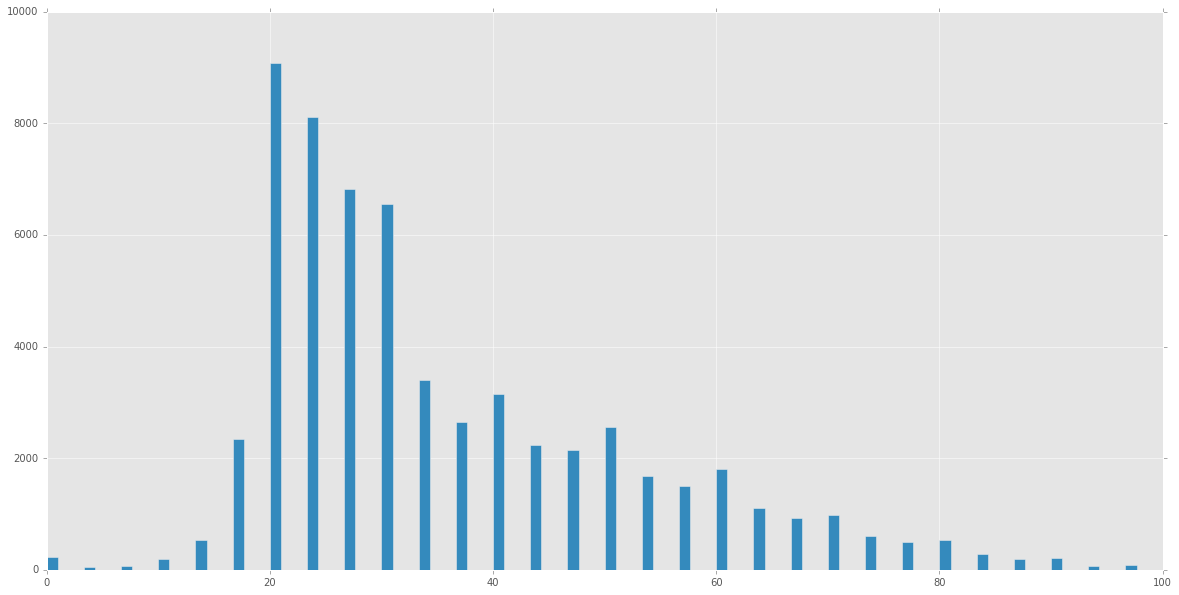

In [98]:
plot_histo(wiki_meta['age'], bins=30)

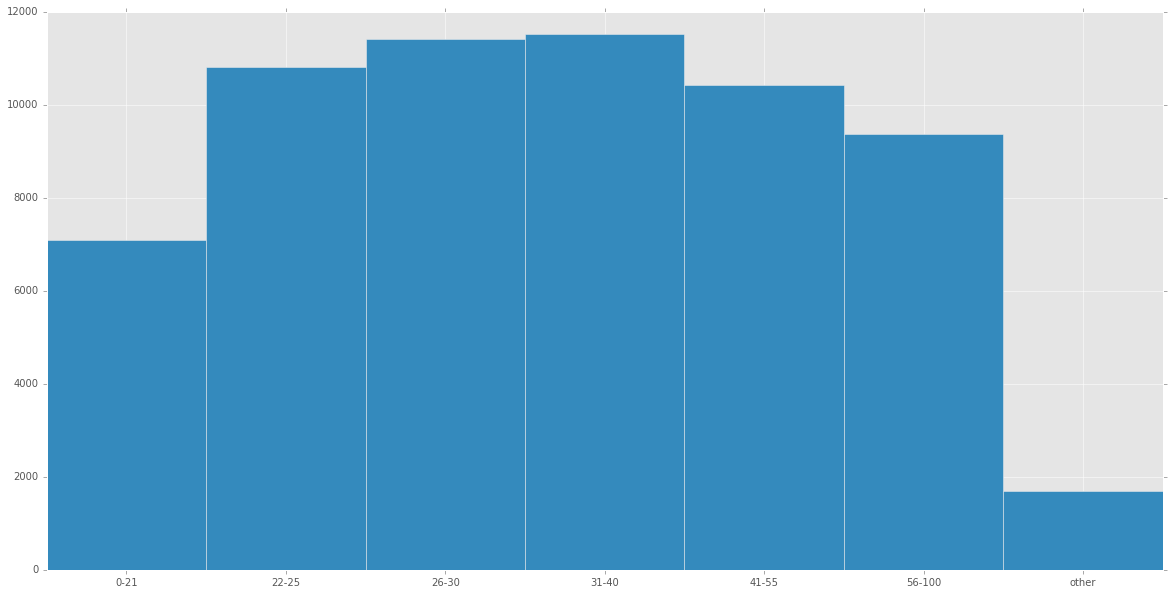

In [97]:
age_classes = [(0,21),(22,25),(26,30),(31,40),(41,55),(56,100)]

age_binned, age_labels = to_bins(wiki_meta['age'], age_classes)

plot_histo(age_binned, bins=range(len(age_labels) + 1), xticks=age_labels)